In [65]:
import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import xgboost

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [3]:
df = pd.read_csv('/content/heart.csv')

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [10]:
df.shape

(303, 14)

**FEATURE ENGINEERING**

In [5]:
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [12]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [21]:
train_df = df.iloc[:, :-1]
y = df['target'].ravel()

train_df.shape, y.shape

((303, 13), (303,))

**FEATURE SELECTION**

USING CORRELATION MATRIX

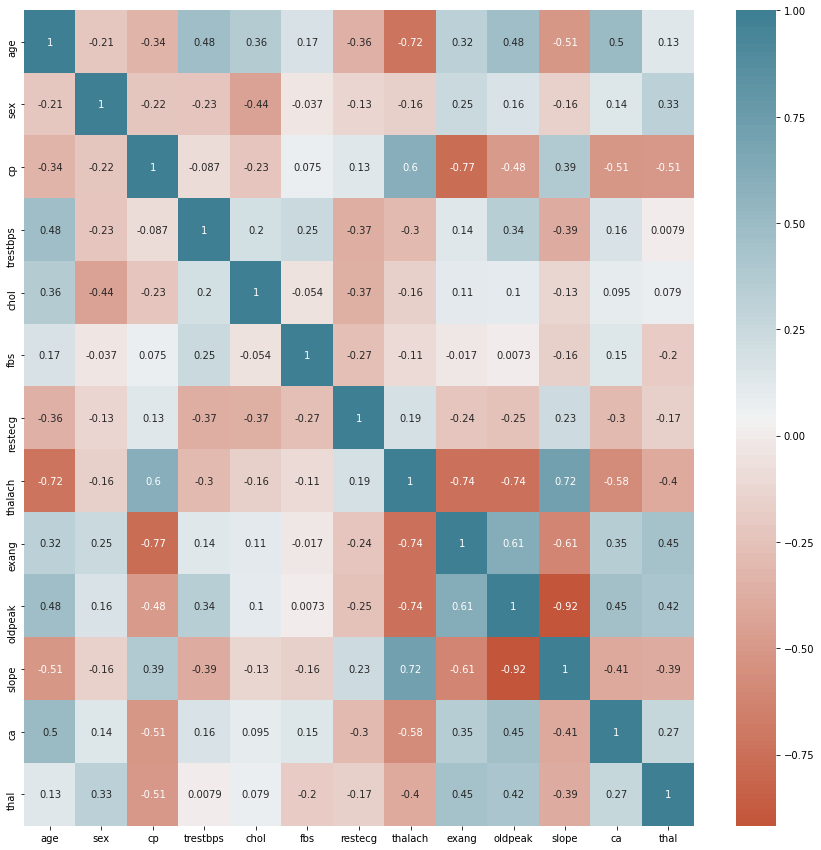

In [24]:
# correlation matrix

corr_mat = train_df.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(15, 15))
g = sns.heatmap(corr_mat[top_corr_features].corr(), annot=True, cmap=sns.diverging_palette(20, 220, n=200))

In [36]:
# find and remove correlated features

threshold = 0.8

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

correlation(train_df.iloc[:,:-1],threshold)

set()

USING K SELECT BEST CHI^2 TEST

In [31]:
# Select K best using Chi^2 test

ordered_rank_features = SelectKBest(score_func=chi2, k=13)
ordered_feature = ordered_rank_features.fit(train_df, y)

dfscores = pd.DataFrame(ordered_feature.scores_, columns=["Score"])
dfcolumns = pd.DataFrame(train_df.columns)

features_rank = pd.concat([dfcolumns, dfscores], axis=1)

features_rank.columns = ['Features','Score']

features_rank.nlargest(13, 'Score')

,Features,Score
7,thalach,188.320472
9,oldpeak,72.644253
11,ca,66.440765
2,cp,62.598098
8,exang,38.914377
4,chol,23.936394
0,age,23.286624
3,trestbps,14.823925
10,slope,9.804095
1,sex,7.576835


USING FEATURE IMPORTANCE - This technique gives you a score for each feature of your data,the higher the score mor relevant it is

In [38]:
model = ExtraTreesClassifier()
model.fit(train_df, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

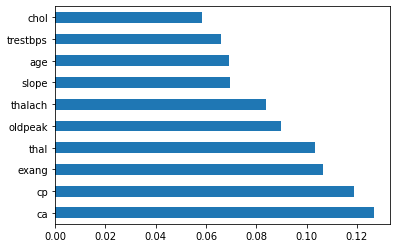

In [39]:
ranked_features = pd.Series(model.feature_importances_, index=train_df.columns)
ranked_features.nlargest(10).plot(kind='barh')
plt.show()

USING INFORMATION GAIN

In [41]:
mutual_info = mutual_info_classif(train_df, y)

In [42]:
mutual_data = pd.Series(mutual_info, index=train_df.columns)
mutual_data.sort_values(ascending=False)

cp          0.157512
ca          0.125396
thal        0.098919
exang       0.089696
slope       0.087677
oldpeak     0.085162
chol        0.083242
thalach     0.075302
sex         0.042916
restecg     0.004994
fbs         0.000000
trestbps    0.000000
age         0.000000
dtype: float64

**FINAL SELECTION**

In [43]:
final_selected_features = ['ca', 'cp', 'exang', 'thal', 'oldpeak', 'thalach']

In [44]:
X = train_df[final_selected_features]

In [45]:
X.shape

(303, 6)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.15, random_state=42)

RANDOMFOREST

In [54]:
# using random forest classifier

rfc = RandomForestClassifier(random_state=10) # ravel : from (n,m) => (n,)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [57]:
# random forest classifier accuracy:
y_preds = rfc.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 78.26%


XGBOOST

In [61]:
# using xgboost

# hyperparameter optimization

params = {
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [1, 3, 5, 7],
    "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree" : [0.3, 0.4, 0.5, 0.7]
}

clf = xgboost.XGBClassifier()

random_search = RandomizedSearchCV(
    clf, 
    param_distributions=params, 
    n_iter=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=5, 
    verbose=3
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0

In [62]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [64]:
classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
score = cross_val_score(classifier, X_train, y_train, cv=10)
print(score.mean())

0.8250769230769232


In [67]:
# xgboost classifier accuracy:
y_preds = classifier.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 84.78%


In [70]:
# saving trained model
filename = '/content/heart-disease.sav'
pickle.dump(classifier, open(filename, 'wb'))